**Universidade de São Paulo**

**Programa de Educação Continuada - Escola Politécnica**

**Gláucio Soares da Silva  - Nº USP: 15031246**

**Monografia Especialização em Inteligência Artificial**

**TEMA: Aplicação de Redes Neurais Recorrentes em Séries Temporais para Gestão de Recursos Hídricos na Região Metropolitana de São Paulo**

O objetivo desse código é desenvolver e avaliar um modelo preditivo baseado em Redes Neurais Recorrentes do tipo LSTM para previsão do volume útil da Represa Jaguari/Jacareí, integrante do Sistema Cantareira, analisando seu desempenho em diferentes horizontes temporais e comparando-o com métodos estatísticos tradicionais de séries temporais.

1 - IMPORTAÇÃO DAS BIBLIOTECAS

Carrega as bibliotecas de manipulação de dados, visualização, normalização, métricas e construção do modelo LSTM, incluindo também o ARIMA como baseline estatístico para comparação.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# ADIÇÃO (baseline consolidado)
from statsmodels.tsa.arima.model import ARIMA

2 - CONFIGURAÇÃO DO EXPERIMENTO

Define a semente para reprodutibilidade e centraliza os hiperparâmetros do experimento (janela, horizonte, split, epochs, dropout, regularização e early stopping), calculando também o número de blocos para projeção de 720 dias.

In [9]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

@dataclass
class Config:
    csv_path: Path = Path("bd_sistema_cantareira.csv")
    represa: str = "Represa Jaguari/Jacareí"
    target_col: str = "Volume (%)*"
    feature_cols: list[str] = None
    window_size: int = 180
    model_horizon: int = 90
    total_horizon: int = 720
    test_ratio: float = 0.2
    batch_size: int = 64
    max_epochs: int = 300
    dropout: float = 0.3
    l2: float = 1e-4
    learning_rate: float = 1e-3
    early_stop: int = 20

cfg = Config()
cfg.n_blocks = cfg.total_horizon // cfg.model_horizon

3 - LEITURA E ORGANIZAÇÃO DOS DADOS

Lê o CSV, filtra a represa de interesse, converte a coluna de datas e ordena os registros cronologicamente para garantir consistência temporal.

In [10]:
df = pd.read_csv(cfg.csv_path, sep=";", decimal=",", encoding="utf-8-sig")
df = df[df["Represa"] == cfg.represa].copy()
df["Data"] = pd.to_datetime(df["Data"])
df = df.sort_values("Data").reset_index(drop=True)

/tmp/ipython-input-165178860.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Data"] = pd.to_datetime(df["Data"])


 4 - SELEÇÃO DAS VARIÁVEIS

Define o conjunto de variáveis de entrada e a variável alvo em formato univariado, utilizando apenas o volume percentual do reservatório.

In [11]:
feature_cols = [cfg.target_col] if cfg.feature_cols is None else cfg.feature_cols
X = df[feature_cols].values
y = df[[cfg.target_col]].values

5 - NORMALIZAÇÃO DOS DADOS

Ajusta os scalers e transforma X e y para o intervalo [-1, 1], melhorando a estabilidade numérica e a convergência do treinamento do modelo.

In [12]:
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

6 - CRIAÇÃO DO DATASET COM JANELAS TEMPORAIS

Converte a série em um dataset supervisionado com janelas deslizantes, usando 180 dias como entrada e 90 dias futuros como saída (previsão multi-step).

In [13]:
def create_windowed_dataset(X, y, window_size, horizon):
    Xs, ys = [], []
    for i in range(len(X) - window_size - horizon + 1):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size:i+window_size+horizon].flatten())
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_windowed_dataset(
    X_scaled, y_scaled, cfg.window_size, cfg.model_horizon
)

6 - DIVISÃO TREINO / TESTE

Divide as sequências em treino e teste respeitando a ordem temporal, garantindo que a avaliação ocorra apenas em dados futuros.

In [14]:
split_idx = int(len(X_seq) * (1 - cfg.test_ratio))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

BASELINES

7 - FUNÇÕES NAIVE + ARIMA

Define as funções para cálculo de RMSE/MAE/R², cria o baseline Naive (persistência do último valor), implementa a previsão ARIMA e fixa a configuração do modelo ARIMA (p,d,q). ARIMA_ORDER=(5,1,0).

In [15]:
def metrics_flat(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

def naive_last_value_forecast(y_window_last_value, horizon):
    return np.full((horizon,), y_window_last_value, dtype=float)

def arima_forecast(history, horizon, order=(5,1,0)):
    model = ARIMA(history, order=order)
    fit = model.fit()
    fc = fit.forecast(steps=horizon)
    return np.asarray(fc, dtype=float)

ARIMA_ORDER = (5, 1, 0)

8 - SÉRIE ORIGINAL EM ESCALA REAL

 Extrai a série de volume e as datas do dataframe na escala original e define o tamanho total da série para suportar indexação e backtests.

In [16]:
# Série original (escala real)
y_full = df[cfg.target_col].astype(float).values
dates_full = df["Data"].values
n_total = len(y_full)

9 - BASELINE ARIMA

Seleciona pontos ao longo do conjunto de teste, ajusta o ARIMA no histórico até cada ponto, prevê 90 dias e calcula métricas agregadas para o baseline estatístico.

In [17]:
test_indices = np.linspace(split_idx, len(X_seq)-1, num=15, dtype=int)

arima_preds = []
arima_trues = []
arima_idx_kept = []

for i in test_indices:
    t0 = i + cfg.window_size
    hist = y_full[:t0]
    true = y_full[t0:t0+cfg.model_horizon]
    if len(true) < cfg.model_horizon:
        continue

    pred = arima_forecast(hist, cfg.model_horizon, order=ARIMA_ORDER)
    arima_preds.append(pred)
    arima_trues.append(true)
    arima_idx_kept.append(i)

arima_preds = np.array(arima_preds)
arima_trues = np.array(arima_trues)
arima_idx_kept = np.array(arima_idx_kept)

rmse_arima, mae_arima, r2_arima = metrics_flat(arima_trues.flatten(), arima_preds.flatten())

print("=== ARIMA (pontos selecionados do teste) ===")
print(f"ARIMA order={ARIMA_ORDER} | RMSE={rmse_arima:.4f} | MAE={mae_arima:.4f} | R2={r2_arima:.4f}")

=== ARIMA (pontos selecionados do teste) ===
ARIMA order=(5, 1, 0) | RMSE=7.8312 | MAE=5.8073 | R2=0.8616


10 - DEFINIÇÃO DO MODELO LSTM

Monta a arquitetura LSTM empilhada com regularização e dropout, adiciona camadas densas e compila o modelo com Adam e perda MSE.

In [18]:
model = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(cfg.l2),
         input_shape=(cfg.window_size, X_train.shape[2])),
    Dropout(cfg.dropout),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(cfg.l2)),
    Dropout(cfg.dropout),
    Dense(64, activation="relu"),
    Dense(cfg.model_horizon)
])

model.compile(
    optimizer=Adam(cfg.learning_rate),
    loss="mse"
)

print("Estrutura do Modelo LSTM:")
model.summary()

Estrutura do Modelo LSTM:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │         5,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,978 (492.10 KB)

 Trainable params: 125,978 (492.10 KB)

 Non-trainable params: 0 (0.00 B)

11 - TREINAMENTO DO MODELO LSTM

Treina o modelo com validação interna e EarlyStopping monitorando a perda de validação, restaurando os melhores pesos para reduzir overfitting.


In [19]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=cfg.early_stop,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/300
93/93 - 56s - 601ms/step - loss: 0.0972 - val_loss: 0.0225
Epoch 2/300
93/93 - 52s - 557ms/step - loss: 0.0334 - val_loss: 0.0180
Epoch 3/300
93/93 - 52s - 557ms/step - loss: 0.0278 - val_loss: 0.0149
Epoch 4/300
93/93 - 52s - 558ms/step - loss: 0.0258 - val_loss: 0.0151
Epoch 5/300
93/93 - 52s - 558ms/step - loss: 0.0247 - val_loss: 0.0141
Epoch 6/300
93/93 - 83s - 896ms/step - loss: 0.0230 - val_loss: 0.0128
Epoch 7/300
93/93 - 80s - 858ms/step - loss: 0.0222 - val_loss: 0.0123
Epoch 8/300
93/93 - 51s - 552ms/step - loss: 0.0213 - val_loss: 0.0111
Epoch 9/300
93/93 - 82s - 885ms/step - loss: 0.0210 - val_loss: 0.0108
Epoch 10/300
93/93 - 52s - 555ms/step - loss: 0.0202 - val_loss: 0.0102
Epoch 11/300
93/93 - 52s - 555ms/step - loss: 0.0195 - val_loss: 0.0116
Epoch 12/300
93/93 - 52s - 557ms/step - loss: 0.0195 - val_loss: 0.0096
Epoch 13/300
93/93 - 51s - 545ms/step - loss: 0.0191 - val_loss: 0.0094
Epoch 14/300
93/93 - 51s - 551ms/step - loss: 0.0192 - val_loss: 0.0094
E

12 - GRÁFICO DA FUNÇÃO DE PERDA

Plota as curvas de loss e val_loss ao longo das épocas para avaliar convergência e estabilidade do treinamento.

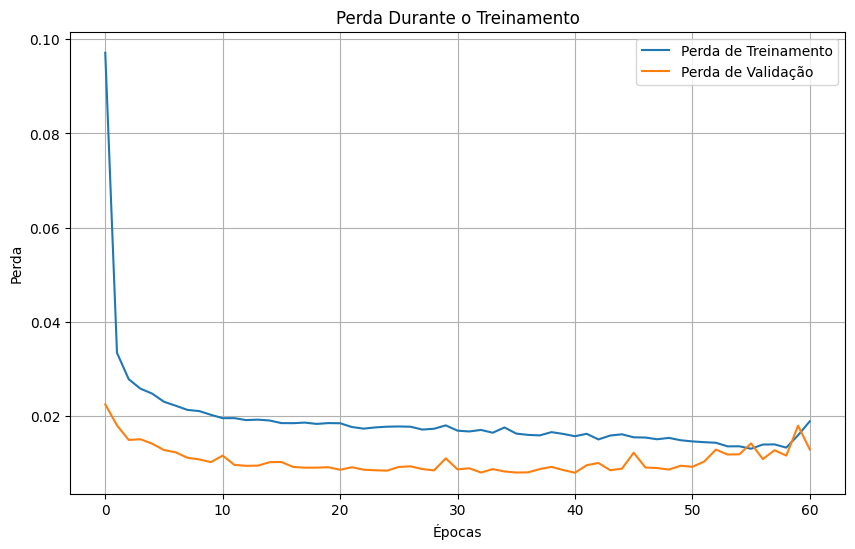

In [20]:
# Plotando o gráfico de perda durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()



13 - AVALIAÇÃO NO TESTE (LSTM)

Gera previsões para o conjunto de teste e desfaz a normalização para obter valores previstos e reais na escala original do volume.

In [21]:
y_test_pred_scaled = model.predict(X_test)

y_test_pred = scaler_y.inverse_transform(
    y_test_pred_scaled.reshape(-1, 1)
).reshape(y_test.shape)

y_test_real = scaler_y.inverse_transform(
    y_test.reshape(-1, 1)
).reshape(y_test.shape)

58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step


In [22]:
# === MÉTRICAS GLOBAIS (LSTM) - TESTE COMPLETO ===
# Avalia o LSTM no conjunto de teste considerando todas as amostras e todo o horizonte (flatten).

y_true_flat = y_test_real.flatten()
y_pred_flat = y_test_pred.flatten()

rmse_lstm_global = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae_lstm_global  = mean_absolute_error(y_true_flat, y_pred_flat)
r2_lstm_global   = r2_score(y_true_flat, y_pred_flat)

# MAPE (percentual) - com proteção contra divisão por zero
eps = 1e-6
mape_lstm_global = np.mean(np.abs((y_true_flat - y_pred_flat) / (np.abs(y_true_flat) + eps))) * 100

print("=== MÉTRICAS GLOBAIS (LSTM) - TESTE COMPLETO ===")
print(f"RMSE: {rmse_lstm_global:.4f}")
print(f"MAE : {mae_lstm_global:.4f}")
print(f"R²  : {r2_lstm_global:.4f}")
print(f"MAPE: {mape_lstm_global:.2f}%")

=== MÉTRICAS GLOBAIS (LSTM) - TESTE COMPLETO ===
RMSE: 6.2379
MAE : 4.5205
R²  : 0.9102
MAPE: 8.86%


14 - BASELINE NAIVE (no mesmo conjunto de teste) + comparação global

Constrói as previsões Naive para cada amostra do teste usando o último valor da janela e compara LSTM e Naive com métricas globais no horizonte completo.

In [23]:
last_vals_scaled = X_test[:, -1, 0].reshape(-1, 1)
last_vals_real   = scaler_y.inverse_transform(last_vals_scaled).flatten()

y_naive_pred = np.vstack([
    naive_last_value_forecast(last_vals_real[i], cfg.model_horizon)
    for i in range(len(last_vals_real))
])

rmse_lstm, mae_lstm, r2_lstm = metrics_flat(y_test_real.flatten(), y_test_pred.flatten())
rmse_nv,  mae_nv,  r2_nv    = metrics_flat(y_test_real.flatten(), y_naive_pred.flatten())

print("=== COMPARAÇÃO (TESTE) - LSTM vs NAIVE (Last Value) ===")
print(f"LSTM  | RMSE={rmse_lstm:.4f} | MAE={mae_lstm:.4f} | R2={r2_lstm:.4f}")
print(f"NAIVE | RMSE={rmse_nv:.4f}  | MAE={mae_nv:.4f}  | R2={r2_nv:.4f}")

=== COMPARAÇÃO (TESTE) - LSTM vs NAIVE (Last Value) ===
LSTM  | RMSE=6.2379 | MAE=4.5205 | R2=0.9102
NAIVE | RMSE=9.5173  | MAE=6.7296  | R2=0.7909


15 - COMPARAÇÃO EXPLÍCITA (mesmos pontos do ARIMA) — LSTM x NAIVE x ARIMA

Constrói as previsões Naive para cada amostra do teste usando o último valor da janela e compara LSTM e Naive com métricas globais no horizonte completo.

In [24]:
# alinhar LSTM/NAIVE aos índices usados no ARIMA
sel = (arima_idx_kept - split_idx)

true_sel = y_test_real[sel]
lstm_sel = y_test_pred[sel]
naive_sel = y_naive_pred[sel]

rmse_lstm_s, mae_lstm_s, r2_lstm_s = metrics_flat(true_sel.flatten(), lstm_sel.flatten())
rmse_nv_s,  mae_nv_s,  r2_nv_s    = metrics_flat(true_sel.flatten(), naive_sel.flatten())

print("=== COMPARAÇÃO (mesmos pontos) ===")
print(f"LSTM  | RMSE={rmse_lstm_s:.4f} | MAE={mae_lstm_s:.4f} | R2={r2_lstm_s:.4f}")
print(f"NAIVE | RMSE={rmse_nv_s:.4f}  | MAE={mae_nv_s:.4f}  | R2={r2_nv_s:.4f}")
print(f"ARIMA | RMSE={rmse_arima:.4f} | MAE={mae_arima:.4f} | R2={r2_arima:.4f}")

=== COMPARAÇÃO (mesmos pontos) ===
LSTM  | RMSE=4.2448 | MAE=3.2515 | R2=0.9593
NAIVE | RMSE=8.6245  | MAE=6.7555  | R2=0.8321
ARIMA | RMSE=7.8312 | MAE=5.8073 | R2=0.8616


16 - BACKTEST NO MEIO DO DATASET (comparar horizonte completo com observado)

Seleciona uma amostra no meio do teste, compara as previsões de 90 dias do LSTM, Naive e ARIMA com o observado, calcula métricas do ponto e plota as curvas ao longo do horizonte.

=== BACKTEST (MEIO DO TESTE) - 90 DIAS ===
idx_test=923 | t0=8485 | data t0=2023-03-26 00:00:00
LSTM  | RMSE=2.4632 | MAE=1.9945 | R2=-8.3145
NAIVE | RMSE=2.6455 | MAE=2.5194 | R2=-9.7446
ARIMA | RMSE=0.7983 | MAE=0.7262 | R2=0.0217


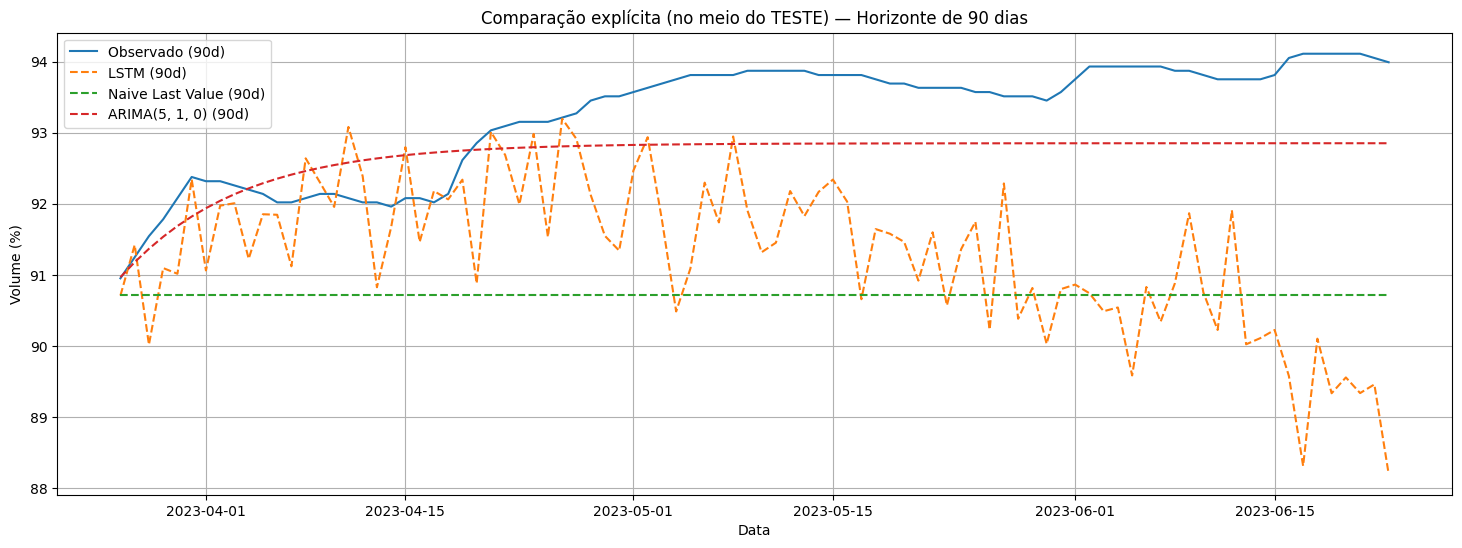

In [25]:
# BACKTEST NO MEIO DO CONJUNTO DE TESTE

# escolhe uma amostra no meio do conjunto de teste
idx_test = len(X_test) // 2

# previsões e valores reais já calculados
true_mid = y_test_real[idx_test]
pred_mid_lstm = y_test_pred[idx_test]
pred_mid_naive = y_naive_pred[idx_test]

# mapear idx_test para o "t0" na série original para criar o eixo de datas
# cada amostra de sequência corresponde ao índice i na construção X_seq/y_seq
# no teste, i = split_idx + idx_test
i_seq = split_idx + idx_test
t0 = i_seq + cfg.window_size  # início do horizonte na série original

dates_mid = df["Data"].iloc[t0:t0 + cfg.model_horizon].values

# ARIMA: histórico até t0 (escala real) e previsão 90 dias
y_full = df[cfg.target_col].astype(float).values
pred_mid_arima = arima_forecast(y_full[:t0], cfg.model_horizon, order=ARIMA_ORDER)

# métricas no ponto
rmse_l, mae_l, r2_l = metrics_flat(true_mid, pred_mid_lstm)
rmse_n, mae_n, r2_n = metrics_flat(true_mid, pred_mid_naive)
rmse_a, mae_a, r2_a = metrics_flat(true_mid, pred_mid_arima)

print("=== BACKTEST (MEIO DO TESTE) - 90 DIAS ===")
print(f"idx_test={idx_test} | t0={t0} | data t0={df['Data'].iloc[t0]}")
print(f"LSTM  | RMSE={rmse_l:.4f} | MAE={mae_l:.4f} | R2={r2_l:.4f}")
print(f"NAIVE | RMSE={rmse_n:.4f} | MAE={mae_n:.4f} | R2={r2_n:.4f}")
print(f"ARIMA | RMSE={rmse_a:.4f} | MAE={mae_a:.4f} | R2={r2_a:.4f}")

# plot
plt.figure(figsize=(18,6))
plt.plot(dates_mid, true_mid, label="Observado (90d)")
plt.plot(dates_mid, pred_mid_lstm, '--', label="LSTM (90d)")
plt.plot(dates_mid, pred_mid_naive, '--', label="Naive Last Value (90d)")
plt.plot(dates_mid, pred_mid_arima, '--', label=f"ARIMA{ARIMA_ORDER} (90d)")
plt.title("Comparação explícita (no meio do TESTE) — Horizonte de 90 dias")
plt.xlabel("Data")
plt.ylabel("Volume (%)")
plt.legend()
plt.grid(True)
plt.show()

17 - DEGRADAÇÃO DE PERFORMANCE LSTM COM O AUMENTO DO HORIZONTE (RMSE/MAE/R² por dia)

Calcula RMSE/MAE/R² para cada dia do horizonte (1 a 90), plota as curvas de degradação e resume as métricas por faixas de horizonte.

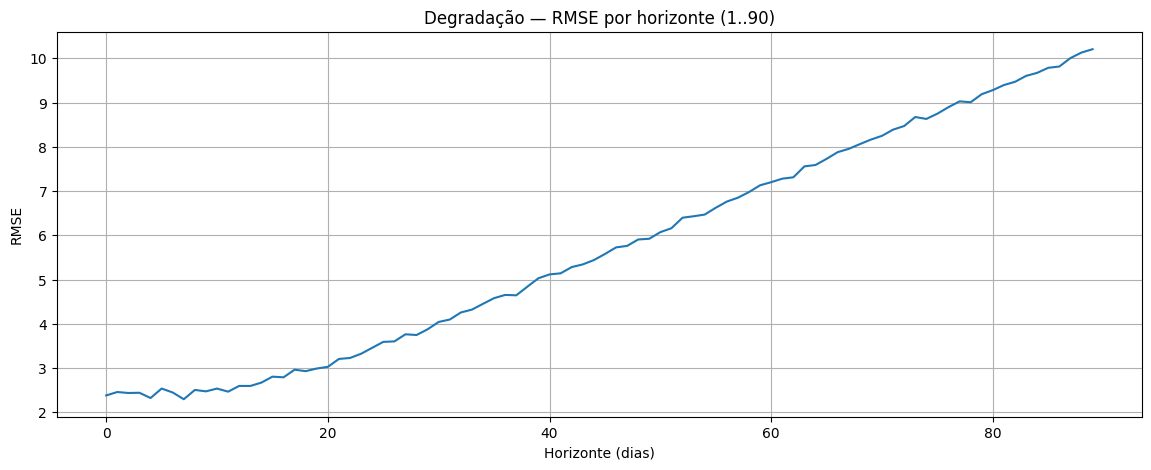

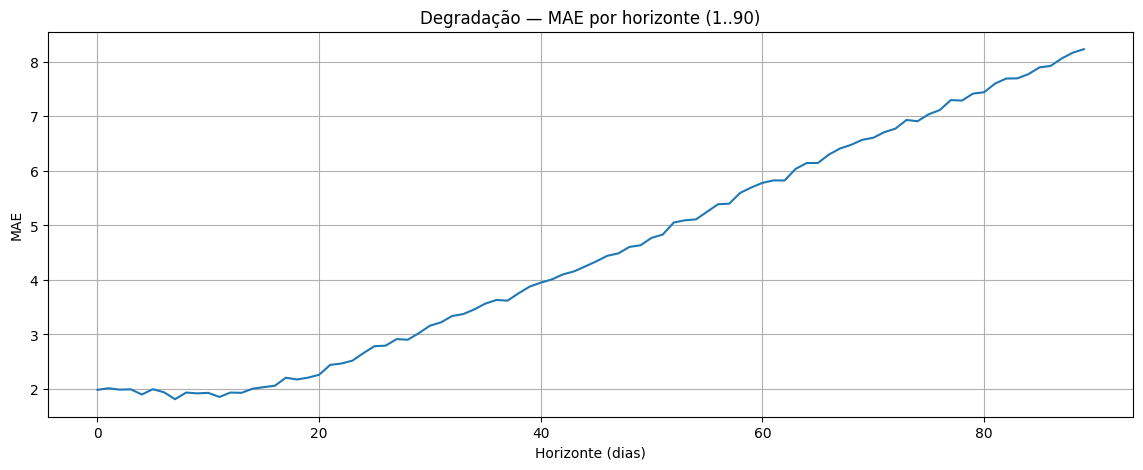

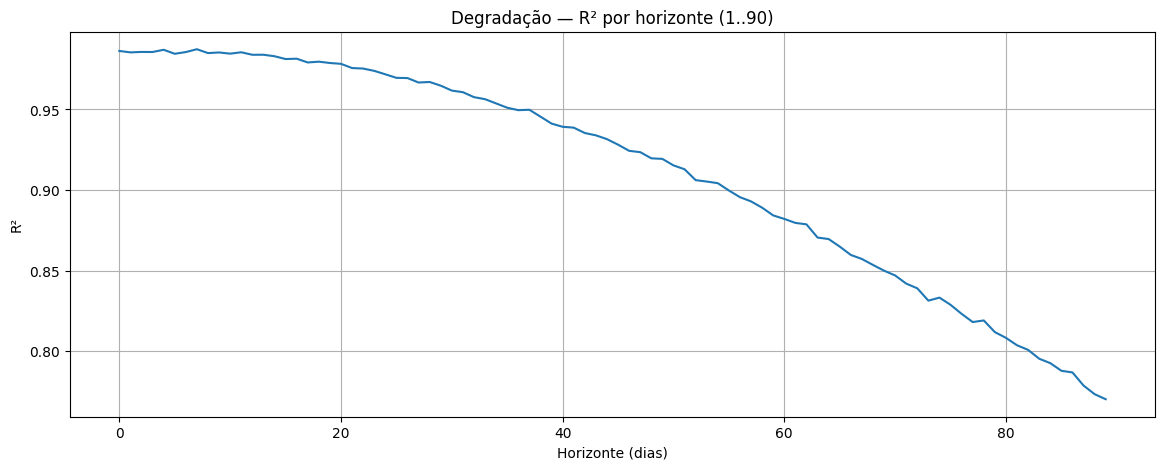

=== RESUMO DA DEGRADAÇÃO (média por faixa) ===
RMSE: {'1-7': 2.43395095980729, '8-30': 3.0209426437148275, '31-60': 5.534883491409483, '61-90': 8.713525024017468}
MAE : {'1-7': 1.9747329608430622, '8-30': 2.2951903034466317, '31-60': 4.339032610320172, '61-90': 7.002061208399292}
R²  : {'1-7': 0.9856930808863316, '8-30': 0.9778562024174555, '31-60': 0.9275349530381446, '61-90': 0.8286150104420847}


In [26]:
import numpy as np
rmse_h = []
mae_h  = []
r2_h   = []

for h in range(cfg.model_horizon):
    yt = y_test_real[:, h]
    yp = y_test_pred[:, h]
    rmse_h.append(np.sqrt(mean_squared_error(yt, yp)))
    mae_h.append(mean_absolute_error(yt, yp))
    r2_h.append(r2_score(yt, yp))

rmse_h = np.array(rmse_h)
mae_h  = np.array(mae_h)
r2_h   = np.array(r2_h)

plt.figure(figsize=(14,5))
plt.plot(rmse_h)
plt.title("Degradação — RMSE por horizonte (1..90)")
plt.xlabel("Horizonte (dias)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
plt.plot(mae_h)
plt.title("Degradação — MAE por horizonte (1..90)")
plt.xlabel("Horizonte (dias)")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
plt.plot(r2_h)
plt.title("Degradação — R² por horizonte (1..90)")
plt.xlabel("Horizonte (dias)")
plt.ylabel("R²")
plt.grid(True)
plt.show()

def summarize_ranges(arr, ranges):
    out = {}
    for (a,b) in ranges:
        out[f"{a}-{b}"] = float(np.mean(arr[a-1:b]))
    return out

ranges = [(1,7), (8,30), (31,60), (61,90)]
print("=== RESUMO DA DEGRADAÇÃO (média por faixa) ===")
print("RMSE:", summarize_ranges(rmse_h, ranges))
print("MAE :", summarize_ranges(mae_h, ranges))
print("R²  :", summarize_ranges(r2_h, ranges))

=== THRESHOLD RMSE (10 pontos percentuais) ===
RMSE ultrapassa 10 p.p. pela primeira vez em: t+88
RMSE no t+88: 10.0060


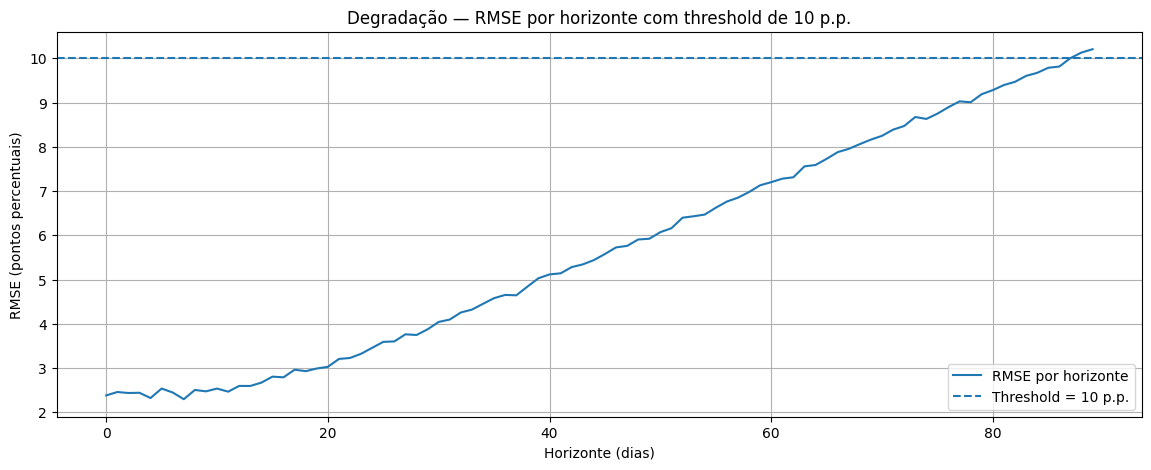

In [33]:
threshold_rmse = 10.0  # 10 pontos percentuais

idx_exceed = np.where(rmse_h > threshold_rmse)[0]

print("=== THRESHOLD RMSE (10 pontos percentuais) ===")
if len(idx_exceed) == 0:
    print("RMSE NÃO ultrapassou 10 p.p. em nenhum dia do horizonte.")
else:
    first_day = int(idx_exceed[0] + 1)
    print(f"RMSE ultrapassa 10 p.p. pela primeira vez em: t+{first_day}")
    print(f"RMSE no t+{first_day}: {rmse_h[idx_exceed[0]]:.4f}")

plt.figure(figsize=(14,5))
plt.plot(rmse_h, label="RMSE por horizonte")
plt.axhline(threshold_rmse, linestyle="--", label="Threshold = 10 p.p.")
plt.title("Degradação — RMSE por horizonte com threshold de 10 p.p.")
plt.xlabel("Horizonte (dias)")
plt.ylabel("RMSE (pontos percentuais)")
plt.legend()
plt.grid(True)
plt.show()

18 - FUNÇÃO DE PREVISÃO DE BLOCOS (720 dias)

Define a rotina que prevê blocos de 90 dias e realimenta a janela com as próprias previsões para iterar até completar 720 dias.

In [28]:
def forecast_in_blocks(model, last_window, n_blocks, block_size):
    forecasts = []
    current_window = last_window.copy()
    for _ in range(n_blocks):
        pred_block = model.predict(
            current_window.reshape(1, *current_window.shape),
            verbose=0
        )[0]
        forecasts.extend(pred_block)
        for p in pred_block:
            new_row = current_window[-1].copy()
            new_row[0] = p
            current_window = np.vstack([current_window[1:], new_row])
    return np.array(forecasts)

19 - FUNÇÃO DE PREVISÃO EM BLOCOS (720 dias) DO RESHAPE

Repete a função de blocos com reshape explícito, garantindo que a janela tenha o formato exigido pelo modelo durante a inferência.

In [29]:
def forecast_in_blocks(model, last_window, n_blocks, block_size):
    forecasts = []
    current_window = last_window.copy()
    for _ in range(n_blocks):
        pred_block = model.predict(
            current_window.reshape(
                1,
                current_window.shape[0],
                current_window.shape[1]
            ),
            verbose=0
        )[0]
        forecasts.extend(pred_block)
        for p in pred_block:
            new_row = current_window[-1].copy()
            new_row[0] = p
            current_window = np.vstack([current_window[1:], new_row])
    return np.array(forecasts)

20 - GERAÇÃO DA PREVISÃO 720 DIAS E INVERSÃO DA ESCALA

Seleciona a última janela disponível, executa a previsão em blocos para 720 dias e aplica a inversão de escala para retornar a projeção ao volume percentual real.

In [30]:
last_window = X_scaled[-cfg.window_size:]

forecast_scaled = forecast_in_blocks(
    model,
    last_window,
    cfg.n_blocks,
    cfg.model_horizon
)

forecast = scaler_y.inverse_transform(
    forecast_scaled.reshape(-1, 1)
).flatten()

21 - CRIAÇÃO DAS DATAS FUTURAS (720 dias)

Gera o eixo temporal futuro a partir do dia seguinte ao último registro do dataset, com 720 datas consecutivas.

In [31]:
future_dates = pd.date_range(
    start=df["Data"].iloc[-1] + pd.Timedelta(days=1),
    periods=cfg.total_horizon
)

22 - PLOT FINAL: SÉRIE HISTÓRICA × PREVISÃO (720 dias)

Plota a série histórica observada junto com a projeção futura de 720 dias para visualização integrada do comportamento previsto.

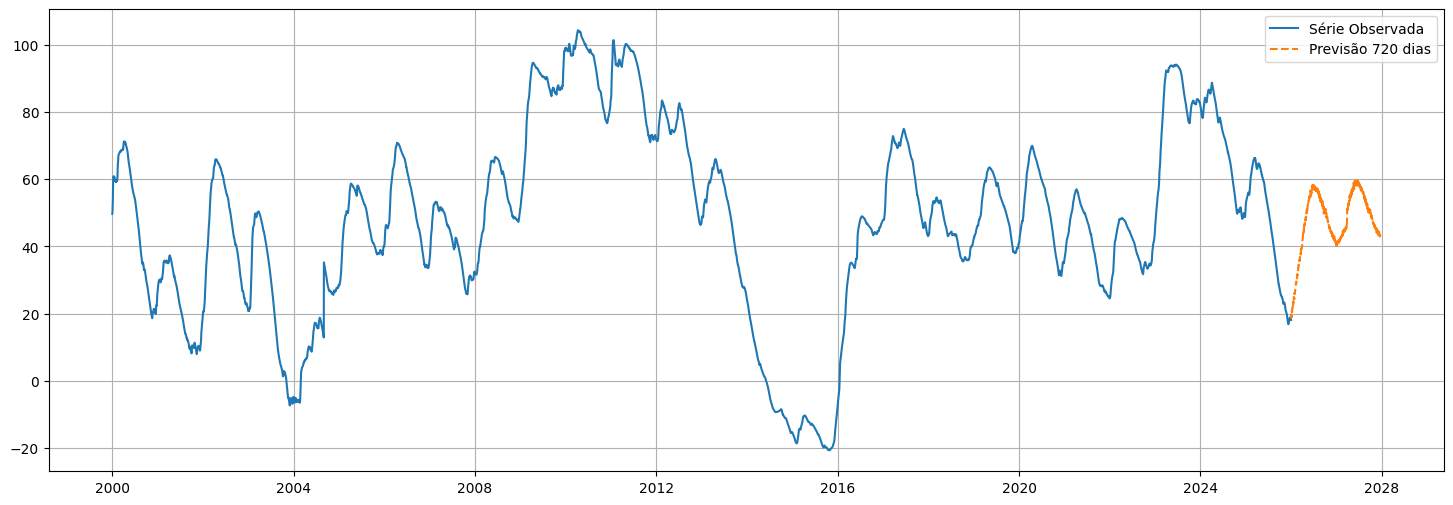

In [32]:
plt.figure(figsize=(18,6))
plt.plot(df["Data"], df[cfg.target_col], label="Série Observada")
plt.plot(future_dates, forecast, '--', label="Previsão 720 dias")
plt.legend()
plt.grid(True)
plt.show()

23 -  CONCLUSÃO

Observa-se que o modelo LSTM se mostrou melhor que o Naive e bastante competitivo com o ARIMA, principalmente em previsões de curto e médio prazo.

Ao analisar cada período de previsão, a precisão diminui conforme períodos mais longos para frente, algo comum em modelos que fazem previsões em etapas. Foi utilizado um modelo de forecast com projeção de longo prazo, para 720 dias, usando uma estratégia iterativa, o que nos permitiu observar a tendência geral, embora com uma suavização natural das previsões.

Em resumo, os resultados sugerem que a arquitetura LSTM é eficaz para modelar o volume de reservatórios, capturando bem os padrões ao longo do tempo. Como o foco deste trabalho foi a demonstração da captura de padrões da rede LSTM, observa-se que para projetos futuros, com finalidade superar os baselines a adição de outras informações poderá melhorar a precisão do modelo.